In [412]:
#! python3 -m pip install graphviz
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.5f}'.format
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM


In [ ]:
def categorify(df, cat_vars):
    categories = {}
    for cat in cat_vars:
        df[cat] = df[cat].astype("category").cat.as_ordered()
        categories[cat] = df[cat].cat.categories
    return categories


def apply_test(test,categories):
    for cat, index in categories.items():
        test[cat] = pd.Categorical(test[cat],categories=categories[cat],ordered=True)

        
def print_results(grid_result):
    para = pd.DataFrame.from_dict(grid_result.cv_results_['params'])
    mean = pd.DataFrame(grid_result.cv_results_['mean_test_score'],columns=['mean_test_score'])
    stds = pd.DataFrame(grid_result.cv_results_['std_test_score'],columns=['std_test_score'])
    time = pd.DataFrame(grid_result.cv_results_['mean_fit_time'],columns=['mean_fit_time'])

    df = para.join(mean.join(stds)).join(time).sort_values('mean_test_score', ascending=False)
    df.reset_index().drop(columns=['index'])
    return df

def plot_accuracy(history):
    losses = history.history['loss']
    accs = history.history['accuracy']
    val_losses = history.history['val_loss']
    val_accs = history.history['val_accuracy']
    epochs = len(losses)

    plt.figure(figsize=(12, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()


# load data
limit = 100000
train = pd.read_csv("train_transaction.csv", nrows=limit)
test = pd.read_csv("test_transaction.csv", nrows=limit)

# generate time of day
train["Time of Day"] = np.floor(train["TransactionDT"]/3600/183)
test["Time of Day"] = np.floor(test["TransactionDT"]/3600/183)

# drop columns
train.drop("TransactionDT",axis=1,inplace=True)
test.drop("TransactionDT",axis=1,inplace=True)

# define continuous and categorical variables
cont_vars = ["TransactionAmt"]
cat_vars = ["ProductCD","addr1","addr2","P_emaildomain","R_emaildomain","Time of Day"] + [col for col in train.columns if "card" in col]

# set training and testing set
x_train = train[cont_vars + cat_vars].copy()
y_train = train["isFraud"].copy()
x_test = train[cont_vars + cat_vars].copy()
y_test = train["isFraud"].copy()


# process cont_vars

# scale values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train["TransactionAmt"] = scaler.fit_transform(x_train["TransactionAmt"].values.reshape(-1,1))
x_test["TransactionAmt"] = scaler.transform(x_test["TransactionAmt"].values.reshape(-1,1))

# reduce cardinality of categorical variables
idx_list = x_train["card1"].value_counts()[x_train["card1"].value_counts()<=100].index.tolist()
x_train.loc[x_train["card1"].isin(idx_list),"card1"] = "Others"
x_test.loc[x_test["card1"].isin(idx_list),"card1"] = "Others"

# fill missing
x_train[cat_vars] = x_train[cat_vars].fillna("Missing")
x_test[cat_vars] = x_test[cat_vars].fillna("Missing")


# convert to integers
categories = categorify(x_train,cat_vars)
apply_test(x_test,categories)
for cat in cat_vars:
    x_train[cat] = x_train[cat].cat.codes+1
    x_test[cat] = x_test[cat].cat.codes+1
    

# imbalanced classes
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_sm, y_train = sm.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_sm,columns=x_train.columns)

# DENOISING DATA

In [383]:

#Change mean and scale of the noise according to your data
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
len_input_output = x_train.shape[-1]
def make_dae():
    dae = Sequential([
        Dense(units=len_input_output*2, 
              activation="relu", input_shape=(len_input_output,)),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output*2, activation="relu"),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output*2, activation="relu"),
        Dropout(0.5), #Add dropout layers if required 
        Dense(units=len_input_output, activation="linear"),
    ])
    dae.compile(
        optimizer='adam', 
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return dae
dae = make_dae()
history = dae.fit(
    x_train_noisy,
    x_train,
    batch_size = 100,
    epochs = 10,
    validation_split=.2
    )

Epoch 1/10
9119/9119 [==============================] - 31s 3ms/step - loss: 6663.0537 - accuracy: 0.7630 - val_loss: 9008.8516 - val_accuracy: 0.8564
Epoch 2/10
9119/9119 [==============================] - 14s 1ms/step - loss: 4605.4443 - accuracy: 0.8076 - val_loss: 5634.4072 - val_accuracy: 0.8708
Epoch 3/10
9119/9119 [==============================] - 13s 1ms/step - loss: 4188.7129 - accuracy: 0.8147 - val_loss: 4906.4058 - val_accuracy: 0.8649
Epoch 4/10
9119/9119 [==============================] - 13s 1ms/step - loss: 3950.1689 - accuracy: 0.8157 - val_loss: 3962.1921 - val_accuracy: 0.8511
Epoch 5/10
9119/9119 [==============================] - 14s 2ms/step - loss: 3763.0842 - accuracy: 0.8204 - val_loss: 3587.4204 - val_accuracy: 0.8623
Epoch 6/10
9119/9119 [==============================] - 14s 2ms/step - loss: 3647.9587 - accuracy: 0.8238 - val_loss: 3454.5874 - val_accuracy: 0.8675
Epoch 7/10
9119/9119 [==============================] - 14s 1ms/step - loss: 3562.6958 - accur

In [441]:
x_train_denoised = dae.predict(x_train)
x_train_denoised.shape

(19470, 13)

In [442]:
y_train.shape

(19470,)

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_249 (Dense)            (None, 100)               1400      
_________________________________________________________________
dense_250 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_104 (Bat (None, 100)               400       
_________________________________________________________________
dropout_167 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_105 (Bat (None, 100)               400       
_________________________________________________________________
dropout_168 (Dropout)        (None, 100)             

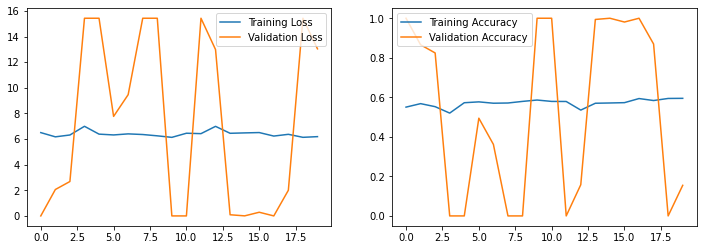

In [443]:
def create_model(units=10, num_layers=2, learning_rate=0.01):
    layers=[]
    for i in range(num_layers):
        if i == 0 :
            layers += [
                tf.keras.layers.Dense(units, activation='relu', input_shape=(13,))
            ]
        else:
            layers += [
                tf.keras.layers.Dense(units, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.2)
            ]
    layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(layers)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])
    
    return model

#model = KerasClassifier(build_fn=create_model)

model = create_model(units=100, num_layers=5, learning_rate=0.01)
model.summary()
history = model.fit(x_train_denoised, y_train.values, epochs=10, validation_split=.15, batch_size=100)
plot_accuracy(history)

In [370]:
y_pred = model.predict(x_test)
y_pred.shape
roc = sklearn.metrics.roc_auc_score(y_test,y_pred)
roc

0.5660665524600441

# Conv2D